In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression

# Задача со звездочкой 8: Экспоненциальный шум
Придумать и реализовать более умную оптимизацию линейной регрессии с экспоненциальным шумом, чем полным перебором по пространству весов. Правильный ответ должен быть неотличим на глаз от предсказаний модели.

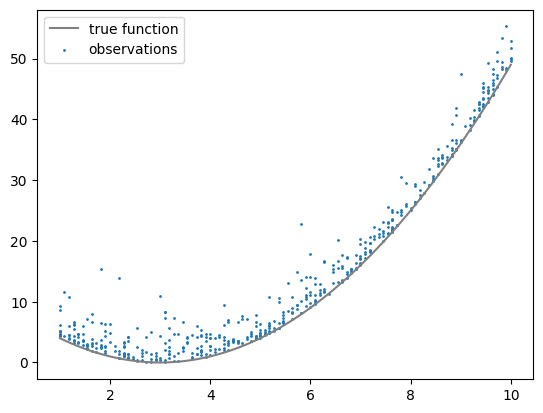

In [2]:
def f_true(x):
    return (x - 3) ** 2


x = np.linspace(1, 10, 100)
x_observed = np.random.choice(x, size=500, replace=True)
y_observed = f_true(x_observed) + np.random.exponential(2.0, len(x_observed))

plt.plot(x, f_true(x), c="grey", label="true function")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

In [3]:
def get_design(x):
    return np.concatenate([x[:, None] ** 2, x[:, None]], axis=1)

def log_likelihood(X, y, W, _lambda=1):
    """
    PDF: lambda * exp (-lambda * x)

    :param X_data: observable features with (bias term at first coordinate)
                    expected shape: (n_samples, n_features + 1)
    :param y: observable target
                    expected shape: (n_samples)
    :param W: weight matrix (with bias term at first coordinate):
                    expexted_shape: (n_features + 1, )
    """
    preds = X @ W
    residuals = y - preds
    # if (residuals < 0).any():
    #     return -99999.0
    log_likelihood = -(residuals).sum()
    return log_likelihood

def constraint(W):
    preds = X @ W
    residuals = y_observed - preds
    return residuals

def add_bias_to_features(X):
    X = np.concatenate([X,np.ones_like(X)[:, 0:1]], axis=-1)
    return X


X = add_bias_to_features(x_observed[:, None])

In [4]:
X = add_bias_to_features(get_design(x_observed))
W = np.zeros(X.shape[-1]).T

constraints = {'type': 'ineq', 'fun': constraint}
res = scipy.optimize.minimize(
    lambda w: -log_likelihood(X, y_observed, w), W, constraints=constraints, method='SLSQP'
)


print("Negative Log Likelihood:", -log_likelihood(X, y_observed, res.x))
print("Optimized weights:", res.x)

Negative Log Likelihood: 1019.8175233319372
Optimized weights: [ 0.99879183 -5.9895885   8.98037234]


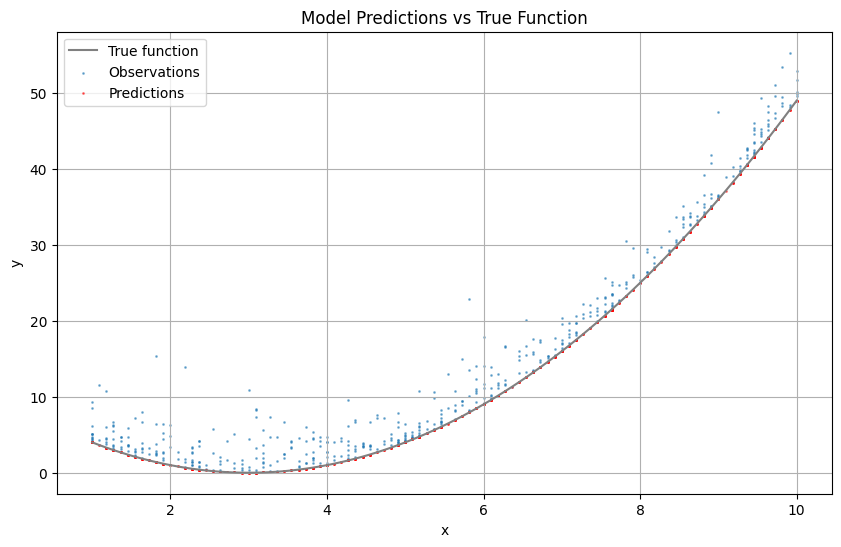

In [5]:
W_optimal = res.x
y_pred = X @ W_optimal

plt.figure(figsize=(10, 6))
plt.plot(x, f_true(x), c="grey", label="True function")
plt.scatter(x_observed, y_observed, s=1.0, label="Observations", alpha=0.5)
plt.scatter(x_observed, y_pred, color='red', s=1.0, label="Predictions", alpha=0.5)
plt.title("Model Predictions vs True Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Задача со звездочкой 9: Эллипс
Вы оказались одни в лесу, и вам очень надо восстановить уравнение эллипса по данным. Как на зло, все что у вас есть - это sklearn.linear_model.LinearRegression.

1 балл. К счастью, вы знаете что эллипс не абы какой, а с осями, параллельными осям координат.

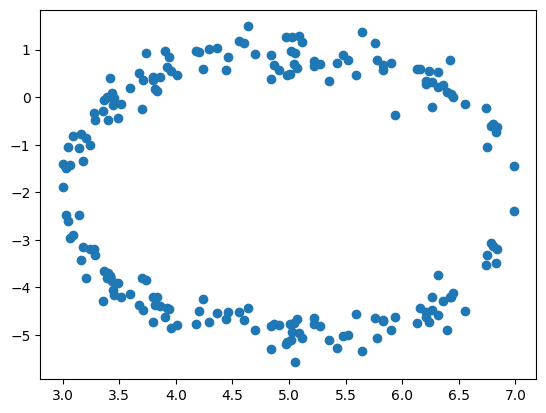

In [6]:
CENTER_X = -5.0
CENTER_Y = 2.0
SCALE_X = 2.0
SCALE_Y = 3.0
ANGLE = np.pi / 6

x = np.random.rand(100) * 2 - 1
y_pos = np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y_neg = -np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y = np.hstack([y_pos, y_neg])
x = x * SCALE_X - CENTER_X
y = y * SCALE_Y - CENTER_Y
x = np.hstack([x, x])
data = np.stack([x, y], axis=1)
plt.scatter(data[:, 0], data[:, 1])

Center of the ellipse: (5.01709551083295, -2.011433320741214)
Semi-major axis (a): 1.8953202027214808
Semi-minor axis (b): 3.0936803756776845


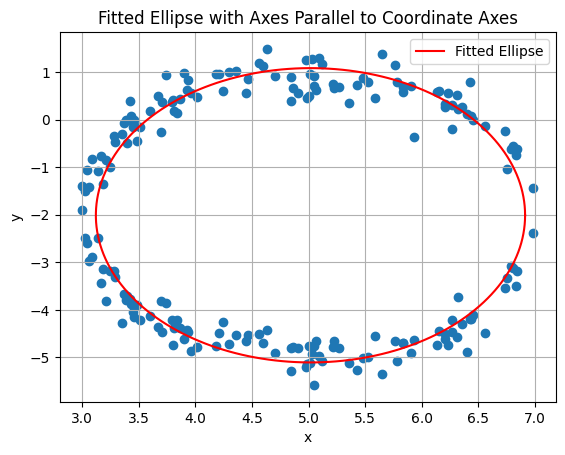

In [7]:
regr = LinearRegression(fit_intercept=False)
X_design = np.vstack([x**2, y**2, x, y]).T
regr.fit(X_design, np.ones_like(x))
A,B,D,E  = regr.coef_
constant = 1 + (D**2) / (4 * A) + (E**2) / (4 * B)
h = -D / (2 * A)
k = -E / (2 * B)
a = np.sqrt(constant / A)
b = np.sqrt(constant / B)





ellipse_theta = np.linspace(0, 2 * np.pi, 200)
ellipse_x = a * np.cos(ellipse_theta) + h
ellipse_y = b * np.sin(ellipse_theta) + k


print(f"Center of the ellipse: ({h}, {k})")
print(f"Semi-major axis (a): {a}")
print(f"Semi-minor axis (b): {b}")


plt.scatter(data[:, 0], data[:, 1])
plt.plot(ellipse_x, ellipse_y, color='red', label='Fitted Ellipse')
plt.title("Fitted Ellipse with Axes Parallel to Coordinate Axes")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

1 балл. А теперь не знаете. (WARNING: я не уверен в том, что это возможно c LinearRegression, но OLS может)

In [8]:
x_rot = x * np.cos(ANGLE) + y * np.sin(ANGLE) + CENTER_X
y_rot = - x * np.sin(ANGLE) + y * np.cos(ANGLE) + CENTER_Y
x_rot += np.random.normal(0, 0.1, x_rot.shape)
y_rot += np.random.normal(0, 0.1, y_rot.shape)

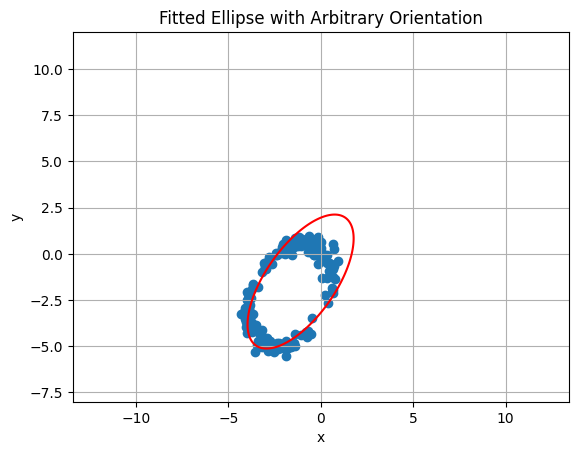

In [9]:
regr = LinearRegression(fit_intercept=False)
X_design = np.vstack([x_rot**2, y_rot**2, x_rot*y_rot, x_rot, y_rot]).T # добавили смешанное произведение
regr.fit(X_design, np.ones_like(x))
A,B,C,D,E = regr.coef_


def plot_ellipse(A, B, C, D, E):
    # Создание сетки
    x = np.linspace(-10, 10, 400)
    y = np.linspace(-8, 12, 400)
    X, Y = np.meshgrid(x, y)

    # Уравнение эллипса
    Z = A * X**2 + B * Y**2 + C * X * Y + D * X + E * Y - 1

    # Построение контуров
    plt.contour(X, Y, Z, levels=[0], colors='red')

plot_ellipse(A, B, C, D, E)



plt.scatter(x_rot, y_rot)

plt.title("Fitted Ellipse with Arbitrary Orientation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')
plt.show()